# Deep Learning -Week 4: Natural Language Processing for Disaster Tweets

In this project, we will use Recursive Neural Networks to predict which tweets are about real disasters and which ones are not.

This Kaggle competition is a binary image classification of tweet texts.  We will build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.

The Kaggle page that contains the details of the compentions can be found inthis URL:

https://www.kaggle.com/c/nlp-getting-started/overview


This notebook can be found in Github :

https://github.com/laguila11/NPL-Disaster-Tweets/

## Step 1. Brief description of the problem and data

In this project, we will have access to a dataset of 10,000 tweets that were hand classified. A positive label indicates that the tweet is actually describing a disaster while a negative label indicates that is not. It’s not always clear whether a person’s words are actually announcing a disaster.

The following data sets are provided in the Kaggle page to train and test the model:

Train tweets :https://www.kaggle.com/competitions/nlp-getting-started/data?select=train.csv Each sample in the train and test set has the following information:
- The text of a tweet
- A keyword from that tweet (although this may be blank!)
- The location the tweet was sent from (may also be blank)

Test tweets : https://www.kaggle.com/competitions/histopathologic-cancer-detection/data?select=test. Each sample in the test set also have:
- id - a unique identifier for each tweet
- text - the text of the tweet
- location - the location the tweet was sent from (may be blank)
- keyword - a particular keyword from the tweet (may be blank)
- target -  this denotes whether a tweet is about a real disaster (1) or not (0)

Submission sample : https://www.kaggle.com/competitions/nlp-getting-started/data?select=sample_submission.csv. Provides a sample submission file in the correct format.


## Step 2. Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In this section we will load the dataset, explore any need to clean the data (remove stop characters) and perform some basic analysis on their contents.

Also we will visualize the different properties to get a first intuition of the contents of the data, the distribution of disaster tweets positive vs negatives and some basic statistics.

In [67]:
import pandas as pd
import re
import matplotlib.pyplot as plt


In [68]:
# Load the train and test datasets
train_path = 'train.csv'
test_path = 'test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


## Data Cleaning & Visualizations

Here will use the standard procedure to remove URLs, special characters and extra spaces from the train dataset and we will produce the visualization of the data and some statistics. 

In [69]:

# Function to clean text data
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

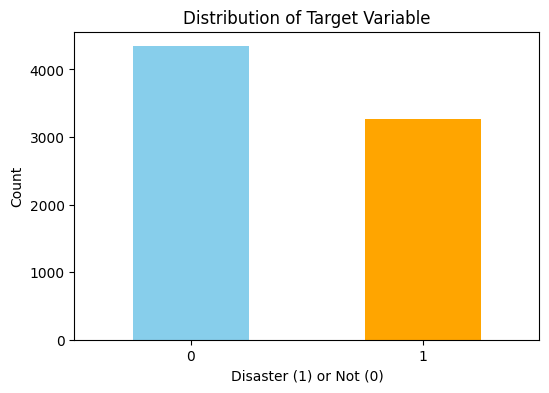

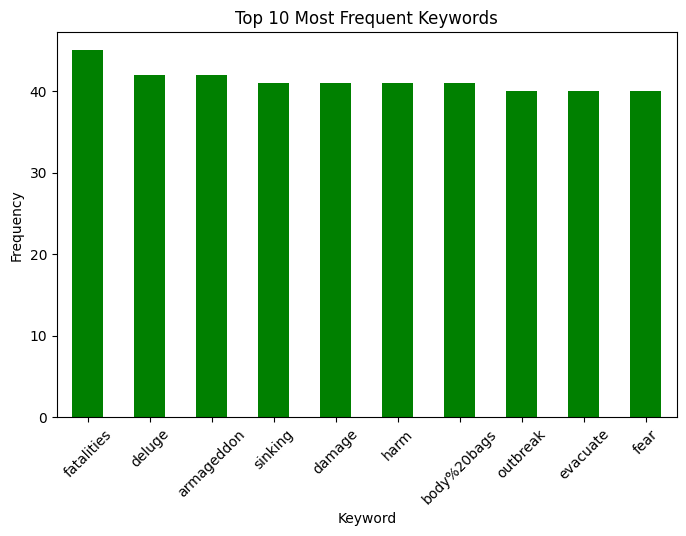

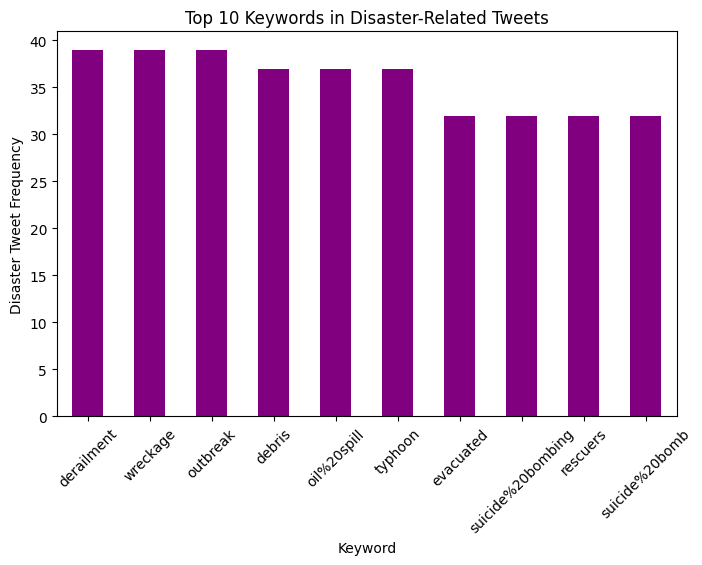

In [72]:


# Function to perform data cleansing and visualizations
def data_cleansing_visualization(df):
    # Cleaning the text column
    df['cleaned_text'] = df['text'].apply(clean_text)
    
    # Plot distribution of the target column (Disaster vs. Non-disaster)
    plt.figure(figsize=(6,4))
    df['target'].value_counts().plot(kind='bar', color=['skyblue', 'orange'])
    plt.title('Distribution of Target Variable')
    plt.xlabel('Disaster (1) or Not (0)')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.show()
    
    # Plot the most frequent keywords
    top_keywords = df['keyword'].value_counts().head(10)
    plt.figure(figsize=(8,5))
    top_keywords.plot(kind='bar', color='green')
    plt.title('Top 10 Most Frequent Keywords')
    plt.xlabel('Keyword')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

    return df




# Call the function with the training dataset
cleaned_train_df = data_cleansing_visualization(train_df)

# Display the cleaned data
cleaned_train_df[['id', 'text', 'cleaned_text', 'target']].head()

# Filter for disaster-related tweets (target = 1) and get the top 10 keywords
keyword_trend = train_df[train_df['target'] == 1]['keyword'].value_counts().head(10)

# Plot the top 10 keywords associated with disaster tweets
plt.figure(figsize=(8,5))
keyword_trend.plot(kind='bar', color='purple')
plt.title('Top 10 Keywords in Disaster-Related Tweets')
plt.xlabel('Keyword')
plt.ylabel('Disaster Tweet Frequency')
plt.xticks(rotation=45)
plt.show()

### Observations


There are more tweets classified as non-disaster (around 4500) compared to disaster tweets (approximately 3500). This suggests that non-disaster tweets are more frequent in the dataset, which could potentially lead to a model biased towards predicting non-disaster tweets.

Keywords like "derailment," "wreckage," "outbreak," "debris," "oil spill," and "typhoon" represent major disaster or accident-related events. These are commonly associated with significant emergencies that could trigger a disaster tweet.

"Evacuated" and "rescuers" indicate post-disaster actions, suggesting that many disaster-related tweets are describing responses to these catastrophic events.

The terms "suicide bombing" and its variant "suicide bomb" suggest that tweets related to terrorism or violence are also being classified as disasters.

## Step 3.  Model Architecture

Here we will describe the different model architectures and reasoning for why the specific architecture might be suitable for this problem. 

We will start with a simple RNN and also test some advanced architectures such as LSTM, GRU, bidirectional RNN, etc.

There are many iterations and tuning of the hyperparameters that have been done outside of this notebook. Here, we are including the most significant changes in the performance of the models. 

After each combination of hyperparameters that produce significant changes in the performance, the results are submitted to Koggle and the score is collected from their application.

At the end of the section, we will compare the multiple architectures and prepare for the results and conclusions.

### Initial steps : Clean text, tokenize and word embedding.

In [81]:
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Embedding, GRU, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam

#  Clean the text
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

train_df['cleaned_text'] = train_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

#  Tokenize the cleaned text and pad sequences
max_words = 5000  # Maximum number of words to consider in vocabulary
max_len = 100     # Maximum length of a sequence (tweet)

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['cleaned_text'])

train_sequences = tokenizer.texts_to_sequences(train_df['cleaned_text'])
test_sequences = tokenizer.texts_to_sequences(test_df['cleaned_text'])

train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post')

train_labels = train_df['target'].values

# Load GloVe word embeddings
embedding_dim = 100  # GloVe embeddings come in various dimensions (50, 100, 200, etc.)
glove_file_path = 'glove.twitter.27B.100d.txt'  # GloVe file path

# Load the GloVe embeddings into a dictionary
embeddings_index = {}
with open(glove_file_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

#  Create the embedding matrix
word_index = tokenizer.word_index  # Vocabulary from the tokenizer
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

###  Comments on word embedding

We are using one of the available tecniques to convert the a matrix form. We pick the file with 200 dimension generated from twitter as we believe has the right contents to this problem.

The original GloVe word convertion reference is here: 
https://nlp.stanford.edu/projects/glove/

The source file with the 200 dimensions is here:
https://www.kaggle.com/datasets/bertcarremans/glovetwitter27b100dtxt

### 1. Simple RNN

Here we will try a simple RNN model. The hyperparameter dropout,& learning rate have already been optmized. Modifying Batch size and Epochs does not yield any better results. We will keep these last two hyperparameters constant in the next 

Dropout = 0.2

Learning rate = 0.01

In [78]:
# Build the model
model = Sequential()

# Embedding layer with GloVe embeddings, non-trainable
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, 
                    input_length=max_len, weights=[embedding_matrix], trainable=False))

# Simple RNN layer
model.add(SimpleRNN(128, return_sequences=False))  # No L2 regularization

# Dropout layer
model.add(Dropout(0.2))  # Keep dropout rate at 0.1

# Dense layer
model.add(Dense(1, activation='sigmoid'))  # No L2 regularization

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_padded, train_labels, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.5319 - loss: 0.7462 - val_accuracy: 0.4951 - val_loss: 0.7396
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5404 - loss: 0.7093 - val_accuracy: 0.5345 - val_loss: 0.6893
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5496 - loss: 0.6984 - val_accuracy: 0.5345 - val_loss: 0.7250
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5304 - loss: 0.7095 - val_accuracy: 0.5345 - val_loss: 0.6943
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5452 - loss: 0.6949 - val_accuracy: 0.5345 - val_loss: 0.6818
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5408 - loss: 0.6971 - val_accuracy: 0.5345 - val_loss: 0.7015
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5414 - loss: 0.7001 - val_accuracy: 0.5345 - val_loss: 0.7069
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5528 - loss: 0.6917 - val_accu

In [82]:
# Make predictions on test data
predictions = model.predict(test_padded)
test_predictions = (predictions > 0.5).astype(int)

# Prepare the submission file
submission_df = pd.DataFrame({
    'id': test_df['id'],      # Use the IDs from the test file
    'target': test_predictions.flatten()  # Flatten the predictions to 1D
})

# Save the submission file
submission_df.to_csv('submission0.csv', index=False)


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


### Kaggle Score

Score: 0.45663

## 2. GRU - Higher learning rate

In this iteration we will change the RNN to a more advanced model (GRU). 
Also we will start with a higher learning rate to see if the model can learn now quicker with the new RNN type. Dropout remains the same.

Dropout = 0.2

Learning rate = 0.1


In [83]:
# Build the GRU model with GloVe embeddings
model = Sequential()

# Embedding layer with GloVe embeddings, non-trainable
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, 
                    input_length=max_len, weights=[embedding_matrix], trainable=False))

# GRU layer for sequential modeling
model.add(GRU(64, return_sequences=False))
model.add(Dropout(0.2))

# Dense layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.1)  # Adjust the learning rate
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

#  Train the model
history = model.fit(train_padded, train_labels, epochs=10, batch_size=32, validation_split=0.2)



Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.5510 - loss: 0.7596 - val_accuracy: 0.5253 - val_loss: 0.7516
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5403 - loss: 0.7675 - val_accuracy: 0.5056 - val_loss: 0.8285
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5445 - loss: 0.7886 - val_accuracy: 0.5292 - val_loss: 0.7456
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5347 - loss: 0.7676 - val_accuracy: 0.5483 - val_loss: 0.7433
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5623 - loss: 0.7470 - val_accuracy: 0.5601 - val_loss: 0.7141
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5442 - loss: 0.7589 - val_accuracy: 0.5555 - val_loss: 0.7122
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5504 - loss: 0.7616 - val_accuracy: 0.5305 - val_loss: 0.7243
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5723 - loss: 0.7625 - val_accuracy: 0.522

In [84]:
# Make predictions on test data
predictions = model.predict(test_padded)
test_predictions = (predictions > 0.5).astype(int)

# Prepare the submission file
submission_df = pd.DataFrame({
    'id': test_df['id'],      # Use the IDs from the test file
    'target': test_predictions.flatten()  # Flatten the predictions to 1D
})

# Save the submission file
submission_df.to_csv('submission.csv', index=False)




102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


### Kaggle Score

Score: 0.67453

## 3. GRU with lower dropout

Since the GRU is delivering better results, we will now try to modify one of the hyperparameters. In particular, the dropout will be reduced as the accuracy is not high enough and the model seems to have room to fit better the training data. We will keep the learning rate the same.

Dropout = 0.1

Learning rate = 0.1


In [85]:
# Build the GRU model with GloVe embeddings
model = Sequential()

# Embedding layer with GloVe embeddings, non-trainable
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, 
                    input_length=max_len, weights=[embedding_matrix], trainable=False))

# GRU layer for sequential modeling
model.add(GRU(64, return_sequences=False))
model.add(Dropout(0.1))

# Dense layer for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.1)  # Adjust the learning rate
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_padded, train_labels, epochs=10, batch_size=32, validation_split=0.2)



Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.6000 - loss: 0.7022 - val_accuracy: 0.7485 - val_loss: 0.5468
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6884 - loss: 0.6195 - val_accuracy: 0.7577 - val_loss: 0.5278
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6746 - loss: 0.6515 - val_accuracy: 0.5890 - val_loss: 0.6874
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6044 - loss: 0.7340 - val_accuracy: 0.5607 - val_loss: 0.8558
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6014 - loss: 0.7184 - val_accuracy: 0.5686 - val_loss: 0.7813
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6008 - loss: 0.7187 - val_accuracy: 0.6211 - val_loss: 0.6569
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.5999 - loss: 0.7056 - val_accuracy: 0.6467 - val_loss: 0.6507
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6103 - loss: 0.7077 - val_accu

In [87]:
# Make predictions on test data
predictions = model.predict(test_padded)
test_predictions = (predictions > 0.5).astype(int)

# Prepare the submission file
submission_df = pd.DataFrame({
    'id': test_df['id'],      # Use the IDs from the test file
    'target': test_predictions.flatten()  # Flatten the predictions to 1D
})

# Save the submission file
submission_df.to_csv('submission2.csv', index=False)


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


### Kaggle score

Score: 0.68188

## 4. GRU with incresed units and slower learning

We continue to fine-tuning other hyperparameters ot improve the model's performance as we seem to be in the right direction. 

GRU Units: We increase the number of units in the GRU layer to see if the model captures more complex patterns. Also reduced the learning rate. Dropout stays the same.

Dropout = 0.1

Learning rate = 0.01
 

In [92]:
# Try increasing the GRU units
model = Sequential()

# Embedding layer with GloVe embeddings, non-trainable
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, 
                    input_length=max_len, weights=[embedding_matrix], trainable=False))

# GRU layer with increased units
model.add(GRU(128, return_sequences=False))  # Increase GRU units from 64 to 128
model.add(Dropout(0.1))  # Keep dropout at 0.1

# Dense layer
model.add(Dense(1, activation='sigmoid'))

# Compile and train the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_padded, train_labels, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.5729 - loss: 0.6818 - val_accuracy: 0.5345 - val_loss: 0.6960
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.5916 - loss: 0.6773 - val_accuracy: 0.5345 - val_loss: 0.6940
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.5789 - loss: 0.6815 - val_accuracy: 0.4649 - val_loss: 0.8642
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.6757 - loss: 0.6247 - val_accuracy: 0.7676 - val_loss: 0.4869
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.7938 - loss: 0.4633 - val_accuracy: 0.7814 - val_loss: 0.4707
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8216 - loss: 0.4087 - val_accuracy: 0.7525 - val_loss: 0.5350
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8250 - loss: 0.4073 - val_accuracy: 0.7899 - val_loss: 0.4570
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.8626 - loss: 0.3219 - val_accu

In [94]:
# Make predictions on test data
predictions = model.predict(test_padded)
test_predictions = (predictions > 0.5).astype(int)

# Prepare the submission file
submission_df = pd.DataFrame({
    'id': test_df['id'],      # Use the IDs from the test file
    'target': test_predictions.flatten()  # Flatten the predictions to 1D
})

# Save the submission file
submission_df.to_csv('submission3.csv', index=False)


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


### Kaggle Score

Score: 0.78577


## 5. Bidirectional GRU

Here we experiment with Bidirectional GRU layers. 

Bidirectional layers read the input sequence both forward and backward, which can help capture more context from the data.

We keep the rest of hyperparameters the same.

In [90]:
from tensorflow.keras.layers import Bidirectional

# Apply Bidirectional GRU
model = Sequential()

# Embedding layer with GloVe embeddings, non-trainable
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, 
                    input_length=max_len, weights=[embedding_matrix], trainable=False))

# Bidirectional GRU layer
model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.1))

# Dense layer
model.add(Dense(1, activation='sigmoid'))

# Compile and train the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_padded, train_labels, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 67ms/step - accuracy: 0.7439 - loss: 0.5199 - val_accuracy: 0.7932 - val_loss: 0.4414
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.8215 - loss: 0.4195 - val_accuracy: 0.7873 - val_loss: 0.4592
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.8484 - loss: 0.3718 - val_accuracy: 0.8011 - val_loss: 0.4584
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.8687 - loss: 0.3173 - val_accuracy: 0.7932 - val_loss: 0.4554
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.8797 - loss: 0.2905 - val_accuracy: 0.7912 - val_loss: 0.5054
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 85ms/step - accuracy: 0.8866 - loss: 0.2786 - val_accuracy: 0.8004 - val_loss: 0.5064
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.8833 - loss: 0.2787 - val_accuracy: 0.7919 - val_loss: 0.5396
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 86ms/step - accuracy: 0.8789 - loss: 0.2974 - 

In [95]:
# Make predictions on test data
predictions = model.predict(test_padded)
test_predictions = (predictions > 0.5).astype(int)

#  Prepare the submission file
submission_df = pd.DataFrame({
    'id': test_df['id'],      # Use the IDs from the test file
    'target': test_predictions.flatten()  # Flatten the predictions to 1D
})

# Save the submission file
submission_df.to_csv('submission4.csv', index=False)


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


### Koggle Score

Score: 0.78823

## 6. LSTM 

While GRU is a simplified version of LSTM, sometimes LSTM (Long Short-Term Memory) networks can perform better on tasks that require more detailed sequential information. LSTM layers could capture longer dependencies in the data.

We will keep the rest of hyperparameters the same.

In [96]:

# Switch from GRU to LSTM
model = Sequential()

# Embedding layer with GloVe embeddings, non-trainable
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, 
                    input_length=max_len, weights=[embedding_matrix], trainable=False))

# LSTM layer
model.add(LSTM(128))
model.add(Dropout(0.1))

# Dense layer
model.add(Dense(1, activation='sigmoid'))

# Compile and train the model
model.compile(optimizer=Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_padded, train_labels, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.5736 - loss: 0.7063 - val_accuracy: 0.5345 - val_loss: 0.6955
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.5939 - loss: 0.6765 - val_accuracy: 0.5345 - val_loss: 0.6932
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.5799 - loss: 0.6813 - val_accuracy: 0.5345 - val_loss: 0.6928
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.5804 - loss: 0.6811 - val_accuracy: 0.5345 - val_loss: 0.6950
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - accuracy: 0.5795 - loss: 0.6822 - val_accuracy: 0.5345 - val_loss: 0.6967
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.5865 - loss: 0.6787 - val_accuracy: 0.5345 - val_loss: 0.6961
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - accuracy: 0.5854 - loss: 0.6788 - val_accuracy: 0.5345 - val_loss: 0.6874
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.5898 - loss: 0.6743 - 

In [97]:
# Make predictions on test data
predictions = model.predict(test_padded)

test_predictions = (predictions > 0.5).astype(int)

# Prepare the submission file
submission_df = pd.DataFrame({
    'id': test_df['id'],      # Use the IDs from the test file
    'target': test_predictions.flatten()  # Flatten the predictions to 1D
})

# Save the submission file
submission_df.to_csv('submission6.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step


### Kaggle Score

Score: 0.63254


## 7. Bidirectional GRU - slower learning rate

Since the best model thas has performed best so far has been the bidirectional GRU with 128 layers, we will no make the final tuning with a slower learning rate to see if the model can capture more features from the texts. The rest of hyperparameters stay the same.

Learning rate = 0.005

In [98]:
# Apply Bidirectional GRU
model = Sequential()

# Embedding layer with GloVe embeddings, non-trainable
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, 
                    input_length=max_len, weights=[embedding_matrix], trainable=False))

# Bidirectional GRU layer
model.add(Bidirectional(GRU(128)))
model.add(Dropout(0.1))

# Dense layer
model.add(Dense(1, activation='sigmoid'))

# Compile and train the model
model.compile(optimizer=Adam(learning_rate=0.005), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_padded, train_labels, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - accuracy: 0.7497 - loss: 0.5116 - val_accuracy: 0.8063 - val_loss: 0.4116
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 15s 80ms/step - accuracy: 0.8184 - loss: 0.4219 - val_accuracy: 0.8030 - val_loss: 0.4463
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - accuracy: 0.8345 - loss: 0.3881 - val_accuracy: 0.8096 - val_loss: 0.4393
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 0.8538 - loss: 0.3446 - val_accuracy: 0.7814 - val_loss: 0.5347
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 0.8959 - loss: 0.2754 - val_accuracy: 0.7932 - val_loss: 0.5002
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 0.9180 - loss: 0.2194 - val_accuracy: 0.7971 - val_loss: 0.6148
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 0.9375 - loss: 0.1784 - val_accuracy: 0.7702 - val_loss: 0.7244
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 0.9482 - loss: 0.1399 - 

In [99]:
# Make predictions on test data
predictions = model.predict(test_padded)

test_predictions = (predictions > 0.5).astype(int)

# Prepare the submission file
submission_df = pd.DataFrame({
    'id': test_df['id'],      # Use the IDs from the test file
    'target': test_predictions.flatten()  # Flatten the predictions to 1D
})

# Save the submission file
submission_df.to_csv('submission5.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


### Kaggle Score

Score: 0.78853


## Step 4. Results and Analysis

### Models Comparison


**Summary table of the 7 combinations tried**

| Combination | Learning Rate | Dropout Rate | # Layers | Loss | Kaggle Score |
|----------|----------|----------|----------|----------|----------|
| 1. Simple RNN| 0.01 | 0.2| 128 | 0.6946 | 0.45663 |
| 2. GRU Higher Learning rate| 0.1 | 0.2| 64 | 0.7640 | 0.67453 |
| 3. GRU Lower Dropout | 0.1 | 0.1| 64 | 0.6997 | 0.68188 |
| 4. GRU with increased units slower learning| 0.01 | 0.1| 128 | 0.2825 | 0.78577 |
| 5. Bidirectional GRU| 0.01 | 0.1| 128 | 0.3437 | 0.78823 |
| 6. LSTM| 0.01 | 0.1| 128 | 0.6016 | 0.63254 |
| 7. Bidirectional GRU slower learning| 0.005 | 0.1| 128 | 0.1151 | 0.78853 |



### Results and analysis

As mentioned in the different steps, we have not been obtained any difference in the performance of the models by modifying the batch size or number of epochs. Also the learning rate at around 0.1 is the result of some trial and error until we got the simple RNN model to show some significant results. After that, the tuning of hyperameters and choice of advance RNN architectues has incresed the performance and Koggle scores.

Here is the detailed analysis:


**1. Simple RNN** struggles to capture complex sequential dependencies, leading to higher loss and lower Kaggle scores. Likely underfitting with a learning rate of 0.01 and lead to consider a more complex architecture.

**2. GRU with Higher Learning Rate**  The model perfomred better than Simple RNNs, and the higher learning rate of 0.1 allowed the model to converge faster but at the cost of higher loss.

**3. GRU with Lower Dropout** Reducing the dropout rate from 0.2 to 0.1 improved the performance, leading to a lower loss and a slightly better Kaggle score.

**4. GRU with Increased Units and Slower Learning** Increasing the number of units to 128 and reducing the learning rate to 0.01 yielded much better results, with significantly lower loss and a higher Kaggle score.Looks like t model had more capacity to learn the data due to the increased number of units.

**5. Bidirectional GRU** The performance of the model was slightly better that the previous one. The combination of 128 units and a 0.01 learning rate seems to be optimal.

**6. LSTM** While LSTM performed reasonably well, it did not outperform GRU-based models in this task. The additional complexity of LSTMs did not provide a significant benefit.

**7. Bidirectional GRU with Slower Learning**  Reducing the learning rate to 0.005 further improved the model’s ability to fine-tune the weights, resulting in the lowest loss and the highest Kaggle score.


## Step 5. Conclusion

The Bidirectional GRU with 128 units, a learning rate of 0.005, and a dropout rate of 0.1 (Combination 7) was the most effective architecture. This combination allowed the model to capture both past and future context from the data while fine-tuning the weights with a slow learning rate, resulting in the best performance with a Kaggle score of 0.78853

**What Helped Improve Performance:**

1. Advanced Architectures: The transition from Simple RNN to GRU and finally to Bidirectional GRU had a significant positive impact on performance. The Bidirectional GRU consistently provided the best results, as seen in Combinations 5 and 7.

2. Learning Rate Tuning: The learning rate was perhaps the most impactful hyperparameter. Initially, higher learning rates (such as 0.1) helped the model converge faster, but they also resulted in higher losses. Reducing the learning rate to 0.01 or 0.005 allowed the model to deliver the best results,

3. Increased Units in RNN Layers: Increasing the number of units in the GRU layers from 64 to 128 helped the model capture more complex patterns in the text data, as shown in Combinations 4, 5, and 7.  

4. Reduced Dropout Rate: Lowering the dropout rate from 0.2 to 0.1 resulted in better generalization, as observed in Combinations 3 through 7. 

**What did not help**

1. Number of epochs: it did not have any effect on the results. The models were converging (or not) in the same number of epochs just by modifying the learning rate or number of RNN layers.

2. Batch sizes: anything different from 32 (lower or higher) delivered worse results. According to the literature, middle sizes (such as 32) often work well for RNN-based models.

**Learnings and Takeaways**

Bidirectional GRU is a powerful architecture for text classification tasks like disaster tweet classification.  Hyperparameter tuning, especially learning rate, is critical for maximizing model performance.  Future improvements could come from incorporating advanced techniques like attention mechanisms, pretrained models, and data augmentation